In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [21]:
stock = 'BGLD'  #GOLD ETF
data = pd.DataFrame()
data["Adj Close"] = yf.download(stock, '2015-07-02', '2023-07-31')['Adj Close']

#Calculate moving average, exponential moving avg might yield better results to a more volatile instrument 
ma = 21
data['MA'] = data.rolling(ma).mean()
data['Returns'] = np.log(data["Adj Close"]).diff()
data["Ratio"] = data["Adj Close"] / data["MA"]
data["Ratio"].describe()

[*********************100%%**********************]  1 of 1 completed


count    614.000000
mean       1.000386
std        0.014290
min        0.967452
25%        0.990676
50%        0.999943
75%        1.010481
max        1.048675
Name: Ratio, dtype: float64

In [26]:
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(data["Ratio"].dropna(), percentiles)

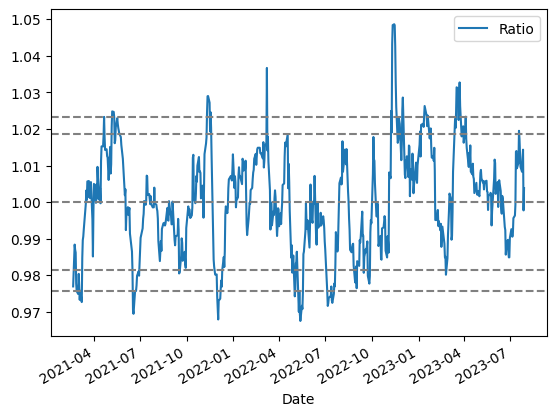

In [28]:
data["Ratio"].dropna().plot(legend = True)
plt.axhline(p[0], c =( .5,.5,.5), ls = "--")
plt.axhline(p[-1], c =( .5,.5,.5), ls = "--")
plt.axhline(p[2], c =( .5,.5,.5), ls = "--")
plt.axhline(p[1], c =( .5,.5,.5), ls = "--")
plt.axhline(p[3], c =( .5,.5,.5), ls = "--")

In [49]:
#Signals, note that the model will always hold a position
short, long = p[-1], p[0]
data["position"] = np.where(data.Ratio> short,-1, np.nan)
data["position"] = np.where(data.Ratio< long,1, data['position'])
data['position'] = data['position'].ffill()

In [50]:
data.sample(10)

,Adj Close,MA,Returns,Ratio,position,strategy returns
Date,,,,,,
2021-11-03,18.683664,18.764003,-0.006111,0.995718,1.0,-0.006111
2021-11-24,18.755371,19.092897,-0.002228,0.982322,-1.0,0.002228
2022-10-20,16.925846,17.197308,-0.001059,0.984215,1.0,-0.001059
2021-07-08,19.380816,19.444176,0.000000,0.996741,1.0,0.000000
2023-07-03,19.620001,19.766810,0.001428,0.992573,-1.0,-0.001428
2022-04-18,19.759270,19.400118,0.004294,1.018513,-1.0,-0.004294
2022-07-13,17.804258,18.225536,0.000392,0.976885,1.0,0.000392
2021-06-09,19.933558,19.982595,0.001250,0.997546,-1.0,-0.001250
2022-03-14,19.391771,19.328553,-0.006858,1.003271,-1.0,0.006858


In [51]:
data['strategy returns'] = data["Returns"] * data['position'].shift()  #shift to stop lookahead bias

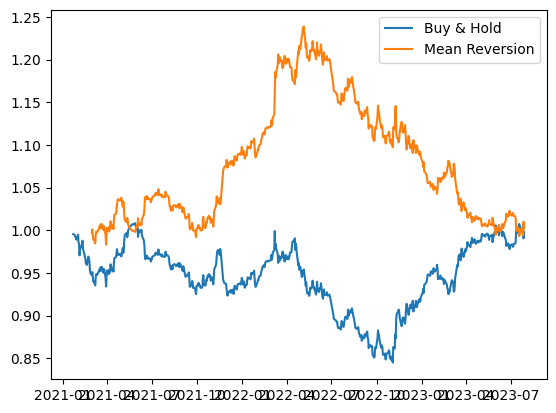

In [52]:
plt.plot(np.exp(data["Returns"].dropna()).cumprod(), label = "Buy & Hold")
plt.plot(np.exp(data["strategy returns"].dropna()).cumprod(), label = "Mean Reversion")
plt.legend()


In [53]:
print("Buy & Hold :" + str(np.exp(data["Returns"].dropna()).cumprod()[-1]-1))
print("Mean Reverting :" + str(np.exp(data["strategy returns"].dropna()).cumprod()[-1]-1))

Buy & Hold :-0.002531275944168465
Mean Reverting :0.0029606267043891243


/var/folders/w_/b3w196fd4k174fs2tf9mr6lh0000gn/T/ipykernel_34208/3176684367.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Buy & Hold :" + str(np.exp(data["Returns"].dropna()).cumprod()[-1]-1))
/var/folders/w_/b3w196fd4k174fs2tf9mr6lh0000gn/T/ipykernel_34208/3176684367.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Mean Reverting :" + str(np.exp(data["strategy returns"].dropna()).cumprod()[-1]-1))


In [ ]:
#